In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()). first()
print(f"The most recent date in the data set is {recent_date}")

The most recent date in the data set is ('2017-08-23',)


Text(0.5, 0, 'Date')

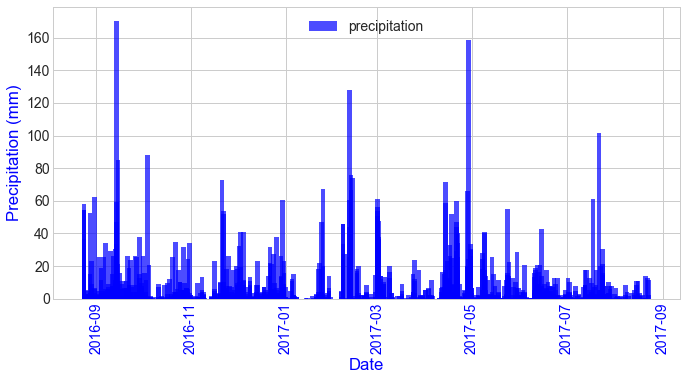

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

one_year_from_recent = dt.date(2017, 8, 23) - dt.timedelta(weeks=52)

# Starting from the most recent data point in the database. 
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()). first()

# Calculate the date one year from the last date in data set.
one_year_from_recent = dt.date(2017, 8, 23) - dt.timedelta(weeks=52)

# Perform a query to retrieve the data and precipitation scores
query_precip = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= one_year_from_recent).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(query_precip, columns=['Date','Precipitation'])

# Sort the dataframe by date
precip_df=precip_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(10, 5))
datw_formatted = np.asarray(precip_df.Date, dtype='datetime64[D]')
ax.bar(datw_formatted, precip_df.Precipitation, color='blue', width=3, alpha=0.7, label='precipitation',edgecolor=None)
ax.tick_params(axis='x', color='red', labelcolor='blue', labelrotation=90)
ax.legend(loc='upper center')
ax.set_ylabel('Precipitation (mm)', color='blue')
ax.set_xlabel('Date', color='blue')



In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2015.000000
mean,4.485112
std,11.690532
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number stations in the dataset
total_stations=session.query(Station.id).count()
print(f'The total number of stations in the data set is {total_stations} ')


The total number of stations in the data set is 9 


In [19]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel1 = (Measurement.station,func.count(Measurement.id))

most_active_station = session.query(*sel1).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
most_active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

sel2 = (Measurement.station,func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))

most_active_query = session.query(*sel2).filter(Measurement.station ==most_active_station[0][0]).all()

print(f"For station {most_active_query[0][0]} the minimum temperature was {most_active_query[0][1]}, \
the maximum {most_active_query[0][2]} and the average {most_active_query[0][3]}")


For station USC00519281 the minimum temperature was 12.2, the maximum 29.4 and the average 22.03582251082252


2017-08-18
2016-08-19


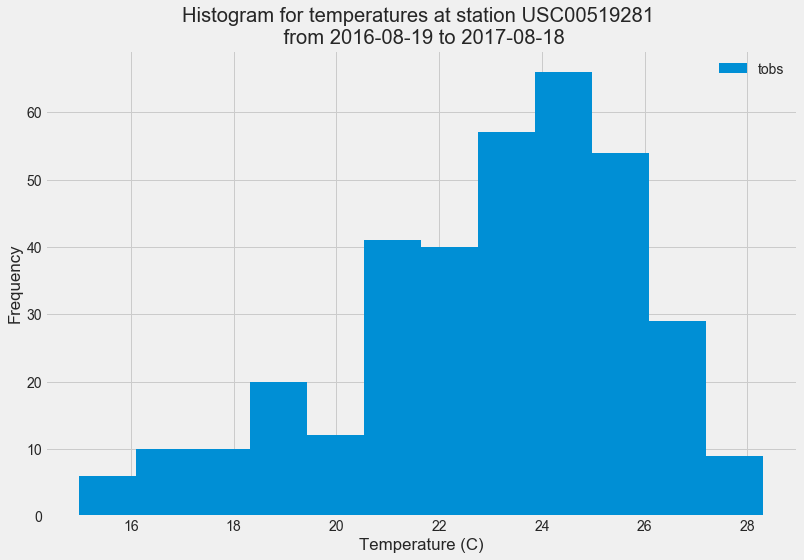

In [28]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_date_forplot = session.query(func.max(Measurement.date)).\
    filter(Measurement.station ==most_active_station[0][0]).all()

last_date_forplot = last_date_forplot[0][0]
print(last_date_forplot)

first_date_forplot = dt.date(2017, 8, 18) - dt.timedelta(weeks=52)
print(first_date_forplot)

most_active_temp = pd.DataFrame(session.query(Measurement.date, Measurement.tobs).\
    # filter to get the most active statio
    filter(Measurement.station ==most_active_station[0][0]).\
     # filter to for the period between start and end date
    filter(Measurement.date<last_date_forplot, Measurement.date>first_date_forplot).all(), columns=['Date','Temp'])

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
plt.hist(most_active_temp['Temp'],bins=12)
plt.ylabel('Frequency')
plt.xlabel('Temperature (C)')
plt.title(f"Histogram for temperatures at station {most_active_query[0][0]} \n from {first_date_forplot} to {last_date_forplot}")
plt.legend(['tobs'], loc='best')

# Close session

In [29]:
# Close Session
session.close()